 <h2><center>HMMs based Part-of-Speech Tagging using Modified Viterbi</center></h2>

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sb
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import time

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
#first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# splitting into train and test  (95% in train, 5% in test)
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=10)
print(len(train_set))
print(len(test_set))

3718
196


In [5]:
# check the data

print(train_set[:10])

[[('The', 'DET'), ('biggest', 'ADJ'), ('firms', 'NOUN'), ('still', 'ADV'), ('retain', 'VERB'), ('the', 'DET'), ('highest', 'ADJ'), ('ratings', 'NOUN'), ('on', 'ADP'), ('their', 'PRON'), ('commercial', 'ADJ'), ('paper', 'NOUN'), ('.', '.')], [('However', 'ADV'), (',', '.'), ('some', 'DET'), ('workers', 'NOUN'), ('have', 'VERB'), ("n't", 'ADV'), ('yet', 'ADV'), ('accepted', 'VERB'), ('the', 'DET'), ('new', 'ADJ'), ('contract', 'NOUN'), ('and', 'CONJ'), ('are', 'VERB'), ('continuing', 'VERB'), ('negotiations', 'NOUN'), (',', '.'), ('the', 'DET'), ('analyst', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('.', '.')], [('IBM', 'NOUN'), ("'s", 'PRT'), ('$', '.'), ('750', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('debenture', 'NOUN'), ('offering', 'NOUN'), ('dominated', 'VERB'), ('activity', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('corporate', 'ADJ'), ('debt', 'NOUN'), ('market', 'NOUN'), ('.', '.')], [('But', 'CONJ'), ('a', 'DET'), ('survey', 'NOUN'), ('early', 'ADV'), ('this', 'D

In [6]:
# Getting list of tagged words

train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95440

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'biggest',
 'firms',
 'still',
 'retain',
 'the',
 'highest',
 'ratings',
 'on',
 'their']

In [8]:
# vocabulary
vocab = set(tokens)
len(vocab)

12007

In [9]:
# number of unique tags

tags = set([pair[1] for pair in train_tagged_words])
len(tags)

12

In [10]:
print(tags)

{'CONJ', 'PRT', 'ADP', 'DET', 'NUM', 'VERB', 'NOUN', 'ADV', '.', 'X', 'PRON', 'ADJ'}


## POS Tagging Algorithm - HMM

### Emission Probabilities

In [11]:
V=len(vocab)
T= len(tags)
w_given_t = np.zeros((T,V))

In [12]:
# compute word given tag (Emission Probabilities)

def emission_probability(word,tag,train_bag=train_tagged_words):
    tag_list=[pair for pair in train_bag if pair[1] == tag]
    count_tag=len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
#cross checking the function 

# the 
print("the\n")
print(emission_probability('the','NOUN'))
print(emission_probability('the','DET'))

the

(1, 27320)
(3848, 8287)


### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def transition_probability(t2,t1,train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# cross checking the function

print(transition_probability(t2='VERB', t1='NOUN'))
print(transition_probability(t2='NOUN', t1='NOUN'))

(4013, 27320)
(7203, 27320)


In [16]:
#Please note P(tag|start) is same as P(tag|'.')

print(transition_probability('DET', '.'))
print(transition_probability('VERB', '.'))
print(transition_probability('NOUN', '.'))

(1910, 11048)
(983, 11048)
(2406, 11048)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = transition_probability(t2, t1)[0]/transition_probability(t2, t1)[1]

In [18]:
tags_matrix

array([[4.66417900e-04, 4.66417894e-03, 5.31716421e-02, 1.21735074e-01,
        4.15111929e-02, 1.55317158e-01, 3.50746274e-01, 5.50373122e-02,
        3.59141789e-02, 8.39552283e-03, 5.97014911e-02, 1.13339551e-01],
       [1.95822446e-03, 1.95822446e-03, 2.12140996e-02, 1.01501308e-01,
        5.48302867e-02, 3.99477810e-01, 2.49673635e-01, 1.04438644e-02,
        4.24281992e-02, 1.27284592e-02, 1.76240206e-02, 8.61618817e-02],
       [8.53697595e-04, 1.28054642e-03, 1.66471023e-02, 3.25045347e-01,
        6.32803366e-02, 8.53697583e-03, 3.20990294e-01, 1.34457368e-02,
        3.94835137e-02, 3.48948874e-02, 6.88293651e-02, 1.06712200e-01],
       [4.82683710e-04, 2.41341855e-04, 9.05031990e-03, 5.43019176e-03,
        2.18414385e-02, 3.92180532e-02, 6.37866557e-01, 1.21877640e-02,
        1.73766147e-02, 4.60962951e-02, 3.25811515e-03, 2.06950650e-01],
       [1.36498520e-02, 2.58160233e-02, 3.56083103e-02, 3.26409494e-03,
        1.84866473e-01, 1.78041551e-02, 3.55192870e-01, 3.26

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,CONJ,PRT,ADP,DET,NUM,VERB,NOUN,ADV,.,X,PRON,ADJ
CONJ,0.000466,0.004664,0.053172,0.121735,0.041511,0.155317,0.350746,0.055037,0.035914,0.008396,0.059701,0.113340
PRT,0.001958,0.001958,0.021214,0.101501,0.054830,0.399478,0.249674,0.010444,0.042428,0.012728,0.017624,0.086162
ADP,0.000854,0.001281,0.016647,0.325045,0.063280,0.008537,0.320990,0.013446,0.039484,0.034895,0.068829,0.106712
DET,0.000483,0.000241,0.009050,0.005430,0.021841,0.039218,0.637867,0.012188,0.017377,0.046096,0.003258,0.206951
NUM,0.013650,0.025816,0.035608,0.003264,0.184866,0.017804,0.355193,0.003264,0.118101,0.208309,0.001187,0.032938
VERB,0.005207,0.031476,0.091008,0.134919,0.022072,0.169193,0.110515,0.081293,0.035362,0.217689,0.036294,0.064972
NOUN,0.042643,0.044546,0.177928,0.013360,0.009810,0.146889,0.263653,0.016947,0.238470,0.028807,0.004795,0.012152
ADV,0.007299,0.014599,0.120770,0.066689,0.032847,0.345720,0.031520,0.078301,0.137027,0.021566,0.014930,0.128733
.,0.058110,0.002444,0.090786,0.172882,0.081644,0.088975,0.217777,0.054218,0.093682,0.027697,0.066618,0.045076
X,0.010064,0.184824,0.144728,0.055272,0.002875,0.206709,0.060863,0.026038,0.162780,0.074121,0.054952,0.016773


In [20]:
tags_df.shape

(12, 12)

In [21]:
tags_df.loc['NOUN',:]

CONJ    0.042643
PRT     0.044546
ADP     0.177928
DET     0.013360
NUM     0.009810
VERB    0.146889
NOUN    0.263653
ADV     0.016947
.       0.238470
X       0.028807
PRON    0.004795
ADJ     0.012152
Name: NOUN, dtype: float32

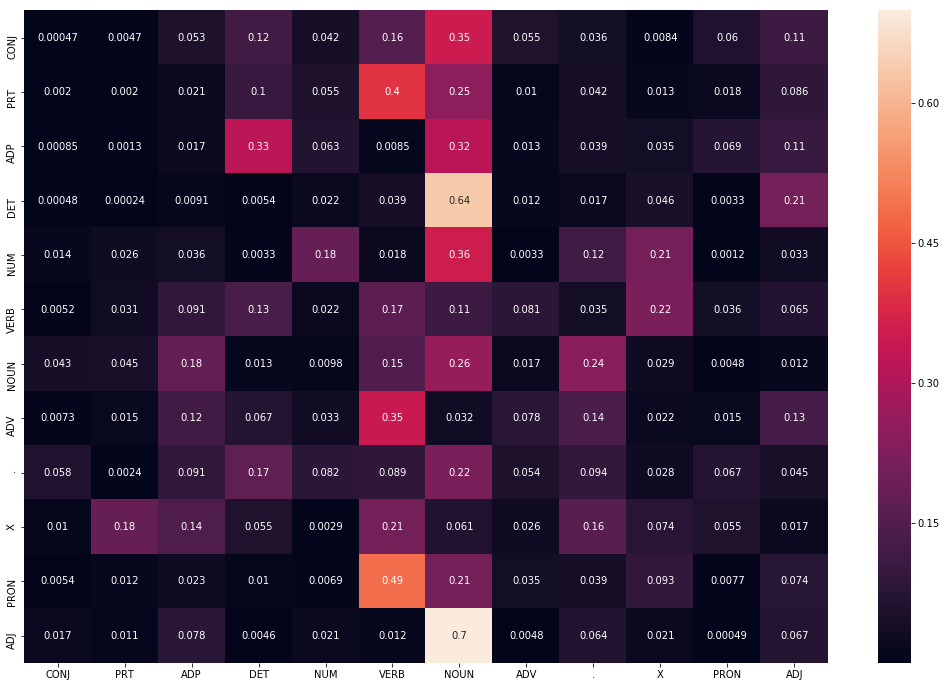

In [22]:
# heatmap of tags matrix

plt.figure(figsize=(18, 12))
sb.heatmap(tags_df,annot=True)
plt.show()

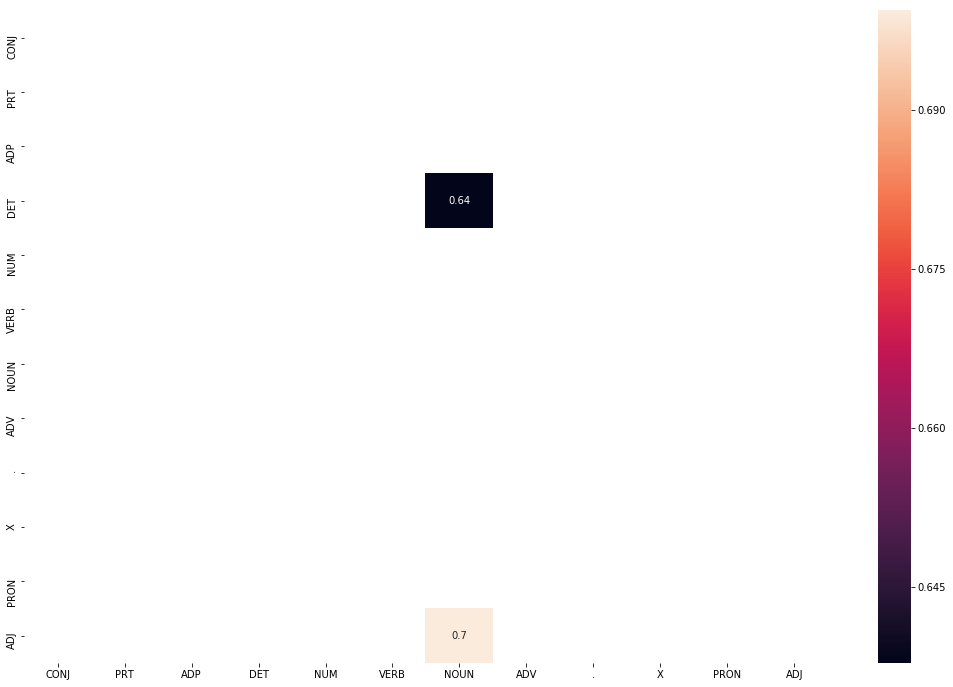

In [23]:
# filter the tags_df to get Transition Probability > 0.5

plt.figure(figsize=(18, 12))
sb.heatmap(tags_df[tags_df>0.5],annot=True)
plt.show()

## Build the vanilla Viterbi based POS tagger

In [24]:
len(train_tagged_words)

95440

In [25]:
# Viterbi Heuristic

'''def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(tags)
    
    for key, word in enumerate(words):
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_probability(words[key], tag)[0]/emission_probability(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))'''

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(tags)                              
    for key, word in enumerate(words):
        p = []
        for tag in T:
            f=lambda x:tags_df.loc['.',tag] if x==0 else tags_df.loc[state[-1],tag]
            n,d=emission_probability(words[key],tag)
            state_probability = (n/d) * f(key)    
            p.append(state_probability)
        # getting state for which probability is maximum
        state.append(T[p.index(max(p))])
    return list(zip(words, state))

## Evaluation of Test Set

In [26]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

#initialize seed number
#random.seed(0)

# choose random five numbers
#randm = [random.randint(1,len(test_set)) for i in range(5)]

# random list of sentences
#test_run = [test_set[i] for i in randm]

# Getting list of tagged words
test_tagged_words = [tup for sent in test_set for tup in sent]


# Getting list of untagged words
test_untagged_words = [tup[0] for sent in test_set for tup in sent]
print(test_untagged_words[:10])

['--', 'The', 'USIA', 'said', 'that', ',', 'on', 'reflection', ',', 'anyone']


In [27]:
# tagging the test sentences

start = time.time()
tagged_seq = Viterbi(test_untagged_words)
end = time.time()
difference = end-start

In [28]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  369.20899987220764
[('--', '.'), ('The', 'DET'), ('USIA', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), (',', '.'), ('on', 'ADP'), ('reflection', 'NOUN'), (',', '.'), ('anyone', 'NOUN'), ('*ICH*-2', 'X'), ('could', 'VERB'), ('view', 'NOUN'), ('the', 'DET'), ('VOA', 'NOUN'), ('materials', 'NOUN'), (',', '.'), ('not', 'ADV'), ('just', 'ADV'), ('the', 'DET'), ('reporters', 'NOUN'), (',', '.'), ('scholars', 'NOUN'), (',', '.'), ('researchers', 'NOUN'), ('and', 'CONJ'), ('congressmen', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('are', 'VERB'), ('mentioned', 'CONJ'), ('*-34', 'X'), ('in', 'ADP'), ('the', 'DET'), ('statute', 'NOUN'), ('.', '.'), ('The', 'DET'), ('12', 'NUM'), ('%', 'NOUN'), ('notes', 'NOUN'), ('due', 'ADJ'), ('1995', 'CONJ'), ('fell', 'VERB'), ('9\\/32', 'CONJ'), ('to', 'PRT'), ('103', 'CONJ'), ('3\\/8', 'NUM'), ('*-1', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('11.10', 'CONJ'), ('%', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN'), ('said', 'VERB'), ('0', 'X'),

In [29]:
# rightly tagged words

check=[i for i,j in zip(tagged_seq,test_tagged_words) if i==j]

In [30]:
#accuracy
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

In [31]:
print("Accuracy of Vanilla Veterbi::  ",vanilla_viterbi_accuracy)

Accuracy of Vanilla Veterbi::   0.894576012223071


In [32]:
# wrongly tagged words
check2=[i for i,j in zip(tagged_seq,test_tagged_words) if i!=j]

In [33]:
check2[:10]

[('view', 'NOUN'),
 ('mentioned', 'CONJ'),
 ('1995', 'CONJ'),
 ('9\\/32', 'CONJ'),
 ('103', 'CONJ'),
 ('11.10', 'CONJ'),
 ('phase-out', 'CONJ'),
 ('closing', 'ADJ'),
 ('Hostess', 'CONJ'),
 ('bakery', 'CONJ')]

In [34]:
check3=[j for i,j in zip(tagged_seq,test_tagged_words) if i!=j]

In [35]:
list(zip(check2,check3))

[(('view', 'NOUN'), ('view', 'VERB')),
 (('mentioned', 'CONJ'), ('mentioned', 'VERB')),
 (('1995', 'CONJ'), ('1995', 'NUM')),
 (('9\\/32', 'CONJ'), ('9\\/32', 'NUM')),
 (('103', 'CONJ'), ('103', 'NUM')),
 (('11.10', 'CONJ'), ('11.10', 'NUM')),
 (('phase-out', 'CONJ'), ('phase-out', 'NOUN')),
 (('closing', 'ADJ'), ('closing', 'NOUN')),
 (('Hostess', 'CONJ'), ('Hostess', 'NOUN')),
 (('bakery', 'CONJ'), ('bakery', 'NOUN')),
 (('Huber', 'CONJ'), ('Huber', 'NOUN')),
 (('introduces', 'CONJ'), ('introduces', 'VERB')),
 (('anti-miscarriage', 'CONJ'), ('anti-miscarriage', 'ADJ')),
 (('that', 'ADP'), ('that', 'DET')),
 (('short', 'ADJ'), ('short', 'ADV')),
 (('further', 'ADV'), ('further', 'ADJ')),
 (('desire', 'CONJ'), ('desire', 'NOUN')),
 (('force', 'VERB'), ('force', 'NOUN')),
 (('len', 'CONJ'), ('len', 'NOUN')),
 (("'s", 'VERB'), ("'s", 'PRT')),
 (('foldability', 'CONJ'), ('foldability', 'NOUN')),
 (('inserted', 'CONJ'), ('inserted', 'VERB')),
 (('incisions', 'CONJ'), ('incisions', 'NOUN'))

In [36]:
# extract unknown words i.e. words which are present in a train set but not present in test set
# so, convert both the train and test set vocab into set and then find the difference i.e. test vocab - train vocab

test_vocab=set(test_untagged_words)
unknown_words=list(test_vocab - vocab)
print("total unknown words:  ",len(unknown_words))
print(unknown_words)

total unknown words:   401
['galling', 'anti-miscarriage', 'S.I.', 'slippery', 'replicate', '11th', 'Orlando', 'loyal', 'word-processing', '*-120', 'Courts', 'polyester', 'malignant', 'assembly-line', 'enclosed', 'Nestor', '19.94', 'appliance', 'Beginning', '13.1', '1637', 'measurement', 'Riserva', 'bribery', 'socialism', 'Coconut', '132', 'cartoonist', '*-96', 'Four', 'literary', 'noble', 'pills', 'Hiroshi', 'disparate', 'Unitholders', 'Grant', 'breaking', '1980', 'Team', 'inserted', 'uncompensated', 'VanSant', '14.99', 'Behind', 'modification', 'Explorer', 'singled', '11.10', 'resolved', 'Aerojet', 'hoopla', 'confrontational', 'Vos', 'proponent', 'Monchecourt', 'Rae', 'sole', 'Hostess', 'diamond', 'polyproplene', 'proprietor', 'Cole', 'Destinations', 'cents-a-unit', 'refuses', 'rarefied', 'reportedly', 'vineyard', 'Russo', 'bombs', 'audiocassettes', 'phase-out', 'one-month', 'Austrian', 'mistrials', '11.72', 'symmetry', '16.09', 'distributes', 'creams', 'kits', 'briefings', 'Legend',

## Solve the problem of unknown words

### METHOD 1: PROBABILISTIC MODEL

In [39]:
# Viterbi Heuristic (Modified)

def Probabilistic_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(tags)
    
    for key, word in enumerate(words):
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            n,d= emission_probability(words[key], tag)
            emission_p = n/d
            
            if word not in vocab:
                state_probability = transition_p   
            else:    
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [40]:
start = time.time()
tagged_seq2 = Probabilistic_Viterbi(test_untagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq2)

Time taken in seconds:  387.11899995803833
[('--', '.'), ('The', 'DET'), ('USIA', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), (',', '.'), ('on', 'ADP'), ('reflection', 'NOUN'), (',', '.'), ('anyone', 'NOUN'), ('*ICH*-2', 'X'), ('could', 'VERB'), ('view', 'NOUN'), ('the', 'DET'), ('VOA', 'NOUN'), ('materials', 'NOUN'), (',', '.'), ('not', 'ADV'), ('just', 'ADV'), ('the', 'DET'), ('reporters', 'NOUN'), (',', '.'), ('scholars', 'NOUN'), (',', '.'), ('researchers', 'NOUN'), ('and', 'CONJ'), ('congressmen', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('are', 'VERB'), ('mentioned', 'X'), ('*-34', 'X'), ('in', 'ADP'), ('the', 'DET'), ('statute', 'NOUN'), ('.', '.'), ('The', 'DET'), ('12', 'NUM'), ('%', 'NOUN'), ('notes', 'NOUN'), ('due', 'ADJ'), ('1995', 'NOUN'), ('fell', 'VERB'), ('9\\/32', 'X'), ('to', 'PRT'), ('103', 'VERB'), ('3\\/8', 'NUM'), ('*-1', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('11.10', 'X'), ('%', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('its', 

In [41]:
check=[i for i,j in zip(tagged_seq2,test_tagged_words) if i==j]
probabilistic_viterbi_accuracy = len(check)/len(tagged_seq2)
print("Accuracy of Probabilistic Veterbi::  ",probabilistic_viterbi_accuracy)

Accuracy of Probabilistic Veterbi::   0.9402215431627197


###  Lexicon and Rule-Based Models for POS Tagging

#### Lexicon (Unigram) Tagger

In [42]:
# lexicon (unigram) tagger
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy = unigram_tagger.evaluate(test_set)
print("Lexicon (Unigram) Tagger accuracy::  ",unigram_accuracy)

Lexicon (Unigram) Tagger accuracy::   0.8917112299465241


#### Rule Based (Regular Expression) Tagger with backoff

In [43]:
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
]

In [44]:
# Rule based and Unigram Backoff

rule_based_tagger = nltk.RegexpTagger(patterns)
unigram_and_rule_based_tagger = nltk.UnigramTagger(train_set,backoff=rule_based_tagger)
unigram_and_rule_based_tagger_accuracy = unigram_and_rule_based_tagger.evaluate(test_set)
print("Unigram and Rule Based tagger accuracy::  ",unigram_and_rule_based_tagger_accuracy)

Unigram and Rule Based tagger accuracy::   0.9495798319327731


In [45]:
# bigram tagger with backoff

bigram_tagger_with_backoff = nltk.BigramTagger(train_set,backoff=unigram_and_rule_based_tagger)
bigram_tagger_with_backoff_accuracy = bigram_tagger_with_backoff.evaluate(test_set)
print("Bigram tagger with backoff accuracy::  ",bigram_tagger_with_backoff_accuracy)

Bigram tagger with backoff accuracy::   0.9522536287242169


In [46]:
# trigram tagger with backoff

trigram_tagger_with_backoff = nltk.TrigramTagger(train_set,backoff=bigram_tagger_with_backoff)
trigram_tagger_with_backoff_accuracy = trigram_tagger_with_backoff.evaluate(test_set)
print("Trigram tagger with backoff accuracy:  ",trigram_tagger_with_backoff_accuracy)

Trigram tagger with backoff accuracy:   0.9530175706646294


### METHOD 2: TRIGRAM TAGGER BACK UP BY BIGRAM AND RULE BASED TAGGER

In [47]:
# trigram function with rule based backoff

def trigram_with_backoff(words,train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    rule_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the rule based tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = rule_based_tagger)
    return trigram_regex_tagger.tag_sents([[(words)]])

In [48]:
# Modified Viterbi with trigram and backup with Rule Based

def Viterbi_backup_trigram(words, train_bag = train_tagged_words):
    state = []
    T = list(tags)
    
    for key, word in enumerate(words):
        if word in vocab:
            p = []
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                 
                # compute emission and state probabilities
                n,d = emission_probability(words[key], tag)
                emission_p = n/d
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            pmax = max(p)
            
            # getting state for which probability is maximum
            
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:  
            trigram_word_tag=trigram_with_backoff(word)
            for sent in trigram_word_tag:
                for tup in sent:
                    state.append(tup[1])
            
    return list(zip(words, state))

In [49]:
#start = time.time()
tagged_seq3 = Viterbi_backup_trigram(test_untagged_words)
#end = time.time()
#difference = end-start

#print("Time taken in seconds: ", difference)
print(tagged_seq3)

[('--', '.'), ('The', 'DET'), ('USIA', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), (',', '.'), ('on', 'ADP'), ('reflection', 'NOUN'), (',', '.'), ('anyone', 'NOUN'), ('*ICH*-2', 'X'), ('could', 'VERB'), ('view', 'NOUN'), ('the', 'DET'), ('VOA', 'NOUN'), ('materials', 'NOUN'), (',', '.'), ('not', 'ADV'), ('just', 'ADV'), ('the', 'DET'), ('reporters', 'NOUN'), (',', '.'), ('scholars', 'NOUN'), (',', '.'), ('researchers', 'NOUN'), ('and', 'CONJ'), ('congressmen', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('are', 'VERB'), ('mentioned', 'VERB'), ('*-34', 'X'), ('in', 'ADP'), ('the', 'DET'), ('statute', 'NOUN'), ('.', '.'), ('The', 'DET'), ('12', 'NUM'), ('%', 'NOUN'), ('notes', 'NOUN'), ('due', 'ADJ'), ('1995', 'NUM'), ('fell', 'VERB'), ('9\\/32', 'NUM'), ('to', 'PRT'), ('103', 'NUM'), ('3\\/8', 'NUM'), ('*-1', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('11.10', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('its', 'PRON'), ('restructuring', 'NOUN'), ('

In [50]:
check2=[i for i,j in zip(tagged_seq3,test_tagged_words) if i==j]
trigram_viterbi_accuracy = len(check2)/len(tagged_seq3)
print("Accuracy of trigram Veterbi::  ",trigram_viterbi_accuracy)

Accuracy of trigram Veterbi::   0.9619938884644768


#### Evaluating tagging accuracy

In [51]:
# create a DataFrame to show all the accuracies of different POS Tagging

accuracy_dct = {'pos_tagging':['Vanilla Veterbi Tagger','Probabilistic Veterbi Tagger',
                               'Rule Based Tagger','Bigram Tagger',
                               'Trigram Tagger','Trigram and Verterbi Tagger'],
               'accuracy':[vanilla_viterbi_accuracy*100,probabilistic_viterbi_accuracy*100,
                          unigram_and_rule_based_tagger_accuracy*100,
                          bigram_tagger_with_backoff_accuracy*100,trigram_tagger_with_backoff_accuracy*100,
                          trigram_viterbi_accuracy*100]}

tagging_df=pd.DataFrame(accuracy_dct)

In [52]:
tagging_df

,accuracy,pos_tagging
0,89.457601,Vanilla Veterbi Tagger
1,94.022154,Probabilistic Veterbi Tagger
2,94.957983,Rule Based Tagger
3,95.225363,Bigram Tagger
4,95.301757,Trigram Tagger
5,96.199389,Trigram and Verterbi Tagger


Text(0.5,1,'Different POS Taggers')

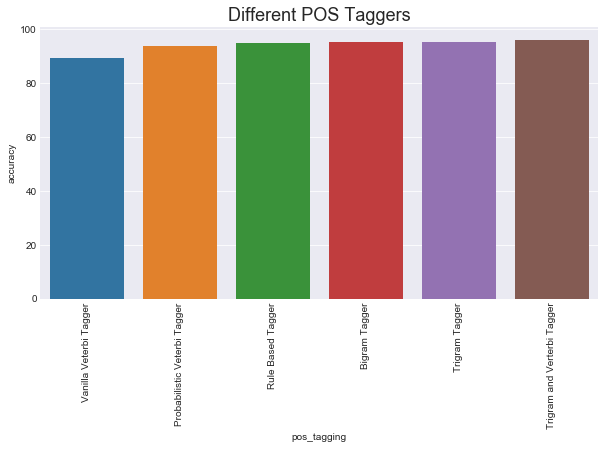

In [53]:
# Visualize the tagging accuracies

sb.set_style('darkgrid')
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sb.barplot('pos_tagging','accuracy',data=tagging_df)
plt.title('Different POS Taggers',fontsize=18)

In [54]:
## Read the data from the file

with open('Test_sentences.txt','r') as f:
    test_sent=f.read().splitlines()[:11]

test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [55]:
# tokenize each words and tag all the words by using NLTK library

test_sent_tokenize=[word_tokenize(sent) for sent in test_sent]
test_sent_tags=nltk.pos_tag_sents(test_sent_tokenize,tagset='universal')
test_sent_tags[:2]

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')]]

In [56]:
# list of tagged and untagged words

test_sent_tagged_words = [i for tup in test_sent_tags for i in tup]


test_sent_untagged_words = [i[0] for tup in test_sent_tags for i in tup]
test_sent_untagged_words[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

In [57]:
# 1. Checking these sentences on Vanilla Veterbi

tagged_seq1 = Viterbi(test_sent_untagged_words)
print(tagged_seq1)
check=[i for i,j in zip(tagged_seq1,test_sent_tagged_words) if i==j]
vanilla_viterbi_accuracy = len(check)/len(tagged_seq1)
print("\n-----------------------------------------------\n")
print("Accuracy of Vanilla Veterbi::  ",vanilla_viterbi_accuracy)

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.'), ('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.'), ('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'CONJ'), ("'s", 'VERB'), ('firehose', 'CONJ'), ('.', '.'), ('Twitter', 'CONJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'CONJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'

In [58]:
# 2. Checking these sentences on Probabilistic Veterbi

tagged_seq2 = Probabilistic_Viterbi(test_sent_untagged_words)
print(tagged_seq2)
check=[i for i,j in zip(tagged_seq2,test_sent_tagged_words) if i==j]
probabilistic_viterbi_accuracy = len(check)/len(tagged_seq2)
print("\n-----------------------------------------------\n")
print("Accuracy of Probabilistic Veterbi::  ",probabilistic_viterbi_accuracy)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

In [59]:
# 3. Checking these sentences on Trigram Veterbi

tagged_seq3 = Viterbi_backup_trigram(test_sent_untagged_words)
print(tagged_seq3)
check=[i for i,j in zip(tagged_seq3,test_sent_tagged_words) if i==j]
trigram_viterbi_accuracy = len(check)/len(tagged_seq3)
print("\n-----------------------------------------------\n")
print("Accuracy of Trigram Veterbi::  ",trigram_viterbi_accuracy)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [60]:
test_accuracy_dct = {'pos_tagging':['Vanilla Veterbi Tagger','Probabilistic Veterbi Tagger',
                                    'Trigram and Verterbi Tagger'],
               'test_sentence_accuracy':[vanilla_viterbi_accuracy*100,probabilistic_viterbi_accuracy*100,
                          trigram_viterbi_accuracy*100]}

test_sentence_df=pd.DataFrame(test_accuracy_dct)
test_sentence_df

,pos_tagging,test_sentence_accuracy
0,Vanilla Veterbi Tagger,75.138122
1,Probabilistic Veterbi Tagger,85.635359
2,Trigram and Verterbi Tagger,93.370166


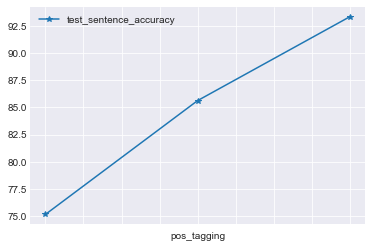

In [61]:
# visualize the accuracies of vanilla veterbi and modified viterbi on test sentences

test_sentence_df.plot.line(x='pos_tagging',y='test_sentence_accuracy',marker='*')

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [62]:
pd.set_option('display.max_rows',200)
dct = {'original_tags':test_sent_tagged_words,'vanilla_viterbi_tags':tagged_seq1,
       'probabilistic_veterbi_tags':tagged_seq2,'trigram_viterbi_tags':tagged_seq3}
tagger_df = pd.DataFrame(dct)
tagger_df.set_index('original_tags',inplace=True)

In [63]:
tagger_df

,probabilistic_veterbi_tags,trigram_viterbi_tags,vanilla_viterbi_tags
original_tags,,,
"(Android, NOUN)","(Android, NOUN)","(Android, NOUN)","(Android, CONJ)"
"(is, VERB)","(is, VERB)","(is, VERB)","(is, VERB)"
"(a, DET)","(a, DET)","(a, DET)","(a, DET)"
"(mobile, ADJ)","(mobile, ADJ)","(mobile, ADJ)","(mobile, ADJ)"
"(operating, NOUN)","(operating, NOUN)","(operating, NOUN)","(operating, NOUN)"
"(system, NOUN)","(system, NOUN)","(system, NOUN)","(system, NOUN)"
"(developed, VERB)","(developed, VERB)","(developed, VERB)","(developed, VERB)"
"(by, ADP)","(by, ADP)","(by, ADP)","(by, ADP)"
"(Google, NOUN)","(Google, DET)","(Google, NOUN)","(Google, CONJ)"


### Case 1

#### As you see above the word 'Android' was incorrectly tagged as 'CONJ' by Vanilla Vertibi algorithm which was correctly tagged by both the modified veteribi algorithm i.e. Probabilistic & Trigram Viterbi as 'NOUN'

### Case 2

#### As you see above the word '2011' was incorrectly tagged as 'CONJ' by Vanilla Vertibi algorithm which was correctly tagged by Modified Trigram Viterbi as 'NUM'

### Case 3

#### As you see above the word 's' was incorrectly tagged as 'VERB' by Vanilla Vertibi algorithm which was correctly tagged by both the modified veterbi algorithm as 'PRT' i.e. (PARTICLE)

## CONSLUSION

#### As per my findings, the VANILLA VETERBI ALGORITHM tagged unknown words mainly  as 'CONJ' which was later corrected by both modified veterbi algorithm.
#### The Vanilla veterbi algorithm also tagged numbers as 'CONJ' which was corrected by modified verterbi algorithm

#### Method 1:   For Probabilistic approach if the words are not found in test set then i used only transition probability which increased the overall accuracy of the algorithm

#### Method 2:  For Viterbi Back up with trigram approach if the words are not found in test set then i used Rule based approach to tagged words as correct as possible which comes out to be the best algorithm so far